# Mô hình Linear Regression (Pytorch)

### Import một số thư viện

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

### Tạo dữ liệu

- Giả sử ta có 1000 điểm dữ liệu phân bố theo hàm **y = f(x) = 2x + 3 + p** 
trong đó p mang giá trị ngẫu nhiên

- Ta cần tìm một hàm xấp xỉ hàm đó chỉ từ những điểm dữ liệu đã có

In [ ]:
m = 2 # slope
c = 3 # intercept

NUM_DATA = 1000

x = np.random.rand(NUM_DATA)
p = np.random.randn(NUM_DATA) / 4
y = x * m + c + p

df = pd.DataFrame()
df['x'] = x
df['y'] = y

### Xử lý dữ liệu

- Đưa dữ liệu về dạng tensor (https://pytorch.org/tutorials/beginner/examples_tensor/two_layer_net_tensor.html)
- Đồng thời gắn vào dữ liệu giá trị bias 

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, dataframe): # Đọc vào pandas dataframe
        self.df = dataframe
        self.load_data()

    def load_data(self):
        self.fns = []
        for idx, row in self.df.iterrows():
            x = np.float(row[0])
            y = np.float(row[1])
            self.fns.append([x,y])
            
    def __getitem__(self, idx):
        x, y = self.fns[idx]
        bias = 1
        x = torch.FloatTensor([x, bias]) # Thêm giá trị bias
        y = torch.FloatTensor([y])
        return x, y
    
    def collate_fn(self, batch):
        x = torch.stack([i[0] for i in batch])
        y = torch.stack([i[1] for i in batch])
        return x, y
    
    def __len__(self):
        return len(self.fns)

### Đưa dữ liệu vào dataloader để chia thành các batch

In [ ]:
dataset = Dataset(df)
dataloader = data.DataLoader(dataset, batch_size = 4, collate_fn=dataset.collate_fn) 

In [ ]:
# Kiểm thử 
batch = next(iter(dataloader))
print(batch)

(tensor([[0.6652, 1.0000],
        [0.7734, 1.0000],
        [0.9022, 1.0000],
        [0.9479, 1.0000]]), tensor([[4.6280],
        [4.6064],
        [5.1302],
        [4.8292]]))


### Biểu diễn dữ liệu

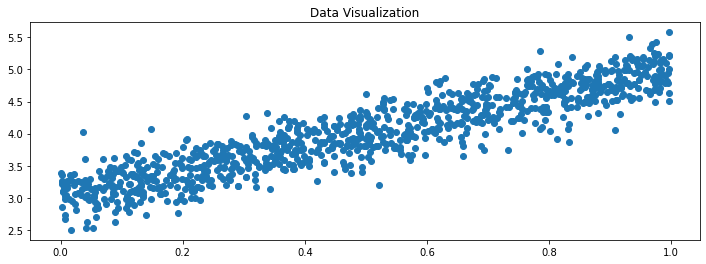

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Data Visualization')
plt.scatter(x,y)
plt.show()

### Khởi tạo mô hình 



Mô hình Linear Regression

<a href="https://imgur.com/Vg0dXBR"><img src="https://i.imgur.com/Vg0dXBR.png" title="source: imgur.com" /></a>

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.w = torch.tensor([1.,1], requires_grad=True) # Cách này thường không dùng, có 2 giá trị là x1 và bias, requires_grad có nghĩa là sẽ lưu giá trị gradient lại
        #self.linear = nn.Linear(input_dim, output_dim)   # Cách này dùng nhiều hơn, trong Linear có sẵn bias
        
        
    def forward(self, x):
        
        # x: batch_size * 2
        # w: 2
        # y_hat: batch_size

        y_hat = x@self.w # Nhân ma trận, thực tế không làm vậy mà dùng lệnh dưới
        
        #out = self.linear(x) 
        return y_hat

In [ ]:
# Hàm lấy giá trị tham số
def get_param_values(model):
    w, b = model.w
    return w.item(), b.item()

### Hàm loss và optimizer



Ta cần làm là tìm hàm xấp xỉ trên, sao cho hàm loss này **đạt cực tiểu**

<a href="https://imgur.com/RkVJz1Q"><img src="https://i.imgur.com/RkVJz1Q.png" title="source: imgur.com" /></a>

Một số hàm loss khác cho việc regression

<a href="https://imgur.com/nIgISP2"><img src="https://i.imgur.com/nIgISP2.png" title="source: imgur.com" /></a>

Thuật toán Gradient Descend
(Nguồn: https://machinelearningcoban.com/2017/01/12/gradientdescent/)

<a href="https://imgur.com/2nuqECB"><img src="https://i.imgur.com/2nuqECB.png" title="source: imgur.com" /></a>

In [ ]:
model = LinearRegressionModel()
criterion = nn.MSELoss() # MSE loss

### Training

- Ta sẽ lấy ra từng batch từ dataloader, sau đó lần lượt đưa vào model
- Sau đi qua model, sẽ cho ra kết quả dự đoán. Ta sẽ tính loss dựa trên kết quả này và grouth truth
- Thực hiện lan truyền ngược (backpropagation) giá trị loss đó cho tất cả các tham số của mô hình
- Thực hiện cập nhật giá trị mới bằng thuật Gradient Descend
- Xóa đi giá trị gradient đang lưu trong bộ nhớ
- Lặp lại quá trình

In [ ]:
# Vẽ đường regression

def plot_current_fit(model, title = ""):
    plt.figure(figsize = (12,4))
    plt.title(title)
    plt.scatter(x, y, s = 8)
    w1, b1 = get_param_values(model)
    x1 = torch.Tensor([0., 1.])       
    y1 = x1 * w1 + b1                 # Hàm y = ax + b
    plt.plot(x1, y1, 'r', label = 'Current Fit ({:.3f}, {:.3f})'.format(w1, b1))
    plt.xlabel('x (input)')
    plt.ylabel('y (target)')
    plt.legend()
    plt.show()

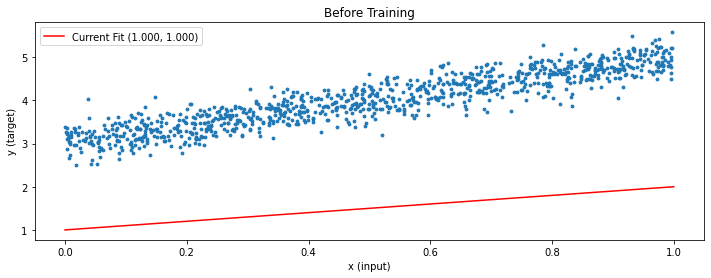

In [ ]:
plot_current_fit(model, title = f'Before Training')

In [ ]:
def train(model, criterion, dataloader):
    NUM_EPOCHS = 10
    LR = 1e-3
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0

        for batch in dataloader:
            inputs = batch[0]                   # lấy điểm đầu vào
            targets = batch[1].squeeze(1)       # giá trị grouth truth
            outputs = model(inputs)             # dự đoán 
            loss = criterion(outputs, targets)  # giá trị loss tính dựa trên giá trị dự đoán và grouth truth
            loss.backward()                     # Tính giá trị đạo hàm cho các tham số trước đó bằng cách lan truyền ngược
            
            # Mini-batch Gradient Descend 
            # Cài đặt thủ công để nhìn trực quan, thực tế không dùng như vậy
            with torch.no_grad():
                model.w -= model.w.grad * LR  # Đi ngược chiều đạo hàm
                model.w.grad.zero_()          # Xóa các giá trị gradient đang được lưu
                
train(model, criterion, dataloader)

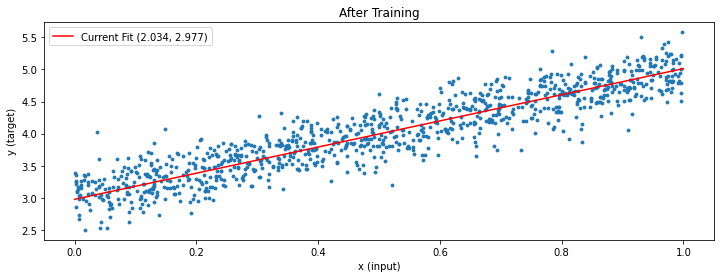

In [ ]:
plot_current_fit(model, title = f'After Training')

# Mô hình Logistic Regression (Pytorch)

### Xử lý dữ liệu

In [ ]:
#Download data from here: https://drive.google.com/file/d/1UL4yj4BYx4N7Sb_2-Xnqh2Rh92DZxwRZ/view?usp=sharing

data_list = []
with open('data.txt', 'r') as f:
    da = f.read()
    lines = da.splitlines()
    for line in lines:
        x1_, x2_, label = line.split(',')
        data_list.append([float(x1_), float(x2_), int(label)])
    data_list = np.array(data_list)
    
df = pd.DataFrame(data = data_list, columns=['x1','x2','y'])

l1 = df[df['y']==0]
l2 = df[df['y']==1]
df

,x1,x2,y
0,34.623660,78.024693,0.0
1,30.286711,43.894998,0.0
2,35.847409,72.902198,0.0
3,60.182599,86.308552,1.0
4,79.032736,75.344376,1.0
...,...,...,...
95,83.489163,48.380286,1.0
96,42.261701,87.103851,1.0
97,99.315009,68.775409,1.0
98,55.340018,64.931938,1.0


### Biểu diễn dữ liệu

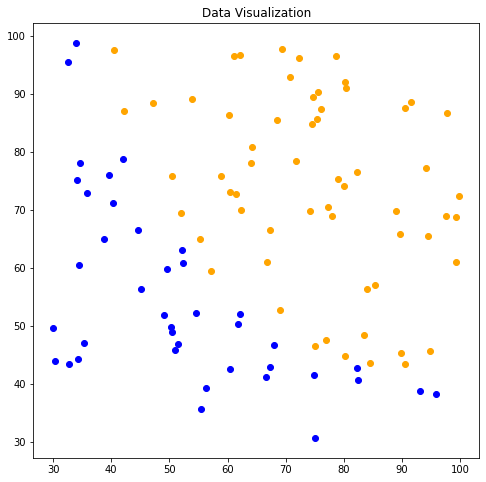

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Data Visualization')
plt.scatter(l1['x1'], l1['x2'], color='blue')
plt.scatter(l2['x1'], l2['x2'], color='orange')
plt.show()

In [ ]:
class BinaryDataset(data.Dataset):
    def __init__(self, dataframe):
        self.df = dataframe
        self.load_data()
    
    def load_data(self):
        self.fns = []
        for idx, row in self.df.iterrows():
            x = np.array(row[:-1])
            y = np.int(row[-1])
            self.fns.append([x,y])
            
    def __getitem__(self, idx):
        x, y = self.fns[idx]
        x = torch.FloatTensor(x)
        y = torch.FloatTensor([y])
        return x, y
    
    def collate_fn(self, batch):
        x = torch.stack([i[0] for i in batch])
        y = torch.stack([i[1] for i in batch])
        return x, y
    
    def __len__(self):
        return len(self.fns)

In [ ]:
dataset = BinaryDataset(df)
dataloader = data.DataLoader(dataset, batch_size=4, collate_fn = dataset.collate_fn, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
print(batch)

(tensor([[34.1836, 75.2377],
        [51.0478, 45.8227],
        [71.7965, 78.4536],
        [97.7716, 86.7278]]), tensor([[0.],
        [0.],
        [1.],
        [1.]]))


In [ ]:
def get_param_values(model):
    [w, b] = model.parameters()
    return w.data[0], b.data[0]

In [ ]:
def plot_current_fit(model, title = ""):
    model.eval()
    plt.figure(figsize = (8,8))
    plt.title(title)
    plt.scatter(l1['x1'], l1['x2'], color='blue')
    plt.scatter(l2['x1'], l2['x2'], color='orange')
    
    with torch.no_grad():
        w, b = get_param_values(model)
        xx = torch.Tensor([30., 100.])
        y = -(w[0] * xx + b)*1.0/w[1]
    plt.plot(xx, y, 'r', label = 'Current Fit ({:.3f}, {:.3f}, {:.3f})'.format(w[0], w[1], b))
    plt.xlabel('x1 (input)')
    plt.ylabel('x2 (input)')
    plt.legend()
    plt.show()

### Khởi tạo mô hình 



Mô hình Logistic Regression

<a href="https://imgur.com/65HaA3O"><img src="https://i.imgur.com/65HaA3O.png" title="source: imgur.com" /></a>

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(0.2)                    # Dropout giúp giảm overfitting dữ liệu
        
    def forward(self, x):
        x = self.dropout(self.linear(x))
        x = torch.sigmoid(x)
        return x

### Hàm loss



Binary cross-entropy Loss

<a href="https://imgur.com/abZJv5m"><img src="https://i.imgur.com/abZJv5m.png" title="source: imgur.com" /></a>

In [ ]:
model = LogisticRegressionModel(2,1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2) # Các thuật toán gradient descend khác: https://ruder.io/optimizing-gradient-descent/

### Training

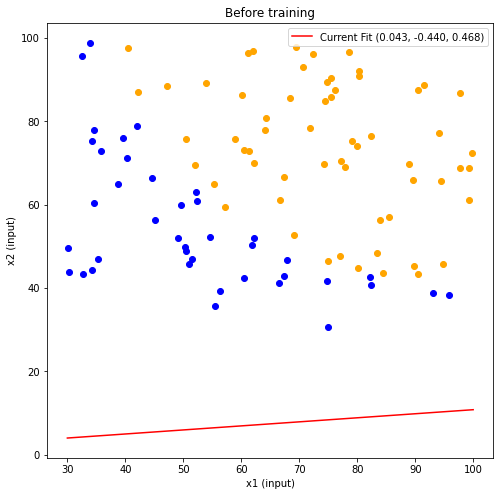

In [ ]:
plot_current_fit(model, title = f'Before training')

In [ ]:
def train(model, criterion, optimizer, dataloader):
    model.train()
    NUM_EPOCHS = 200                            # Một epoch là một lần đi qua hết toàn bộ dữ liệu huấn luyện
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        for batch in dataloader:                # Một lần đọc vào 1 batch 
            optimizer.zero_grad()               # Xóa các gradient hiện có, để không bị cộng dồn các gradient ở batch trước
            inputs = batch[0]
            targets = batch[1]
            outputs = model(inputs)             # Predict
            loss = criterion(outputs, targets)  # Tính loss giữa grouth truth và prediction
            loss.backward()                     # Lan truyền ngược để tính các gradient
            optimizer.step()                    # Cập nhật các gradient cho các tham số của mô hình
            epoch_loss += loss.item()
            
train(model, criterion, optimizer, dataloader)

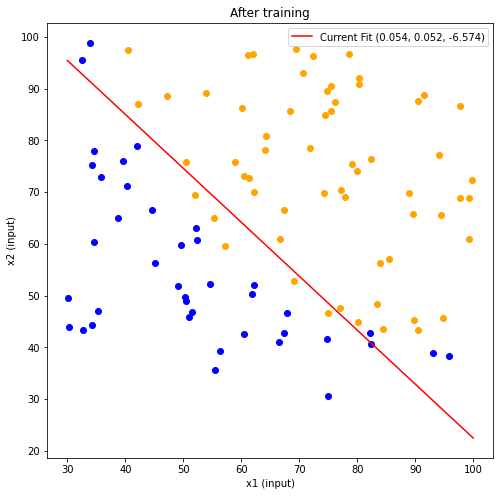

In [ ]:
plot_current_fit(model, title = f'After training')